## Two Way Method

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
from utility_func import *
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import gmtime, strftime
import random
import os

# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting Simulation and Hyperparameters
Setting up the hyperparameters for the training purpose.

$N$: Number of Transmitters. \
$M$: Number of Receivers. \
$L$: Total length of pilot transmission. 

In [2]:
# Define communication parameters 
N = 64                              # Number of transmit antenna
M = 1                               # Number of receive antenna
L = 4                              # Number of ping pong rounds
SNR_dB = torch.tensor(0)            # Signal to Noise Ratio in dB
P_dBm = torch.tensor(0)             # Transmitter and Receiver's power
SNR = 10**(SNR_dB/10)               # Signal to Noise Ratio in linear scale
P = 10**(P_dBm/10)                  # Transmit power in linear scale
N0 = P/SNR                          # Noise power in linear scale

# Define hyperparameters
batch_size = 1024
n_epochs = 20
max_epochs = 50

# Define parameters for NN 
input_sizeTx, input_sizeRx = 2*N*L, 2*L
output_sizeTx, output_sizeRx = 3*N, M                     # Output size of sensing output of A 
sim_parameters = (N, M, L, N0)

### Preparing Sensing Data for Pilot Transmission
Note that it is crucial to use the same sensing data during pilot stage so that the neural network is able to learn the channel distribution.

In [3]:
"""Make sensing polarization vectors and beamformer"""
# Polarization vectors used in pilot stage
Pol_Tx, Pol_Rx, Pol_Tx_t_blk, Pol_Rx_t_blk = MISO_polarization_pilot_tensor(N, M, L)
Pol_Tx_r_blk_T = torch.transpose(Pol_Tx_t_blk, 1, 2)
Pol_Rx_r_blk_T = torch.transpose(Pol_Rx_t_blk, 1, 2)

# Transmit beamformer used in the pilot stage
W_A_t_real = torch.randn((L, 1, N))
W_A_t_imag = torch.randn((L, 1, N))
W_A_t = torch.complex(W_A_t_real, W_A_t_imag)
W_A_t = W_A_t / torch.norm(W_A_t, dim=2, keepdim=True)
W_A_t = torch.transpose(W_A_t, 1, 2) * torch.sqrt(P)

### Preparing Training Data

In [4]:
"""Generate H_p channel batch data"""
# total number of generated samples
num_generated_sample = batch_size * 100 
# H_p generation
H_p_training_shaped = channel_generation_batch_tensor(num_generated_sample, N, M)
y_real_tx_train, y_real_rx_train = generate_twoway_pilots(H_p_training_shaped, Pol_Tx_t_blk, 
                                                          Pol_Tx_r_blk_T, Pol_Rx_t_blk, Pol_Rx_r_blk_T, 
                                                          W_A_t, sim_parameters)

### Preparing Test Data

In [5]:
"""Generate H_p channel batch data"""
# total number of generated samples
num_generated_testing_sample = 1000
# H_p generation
H_p_testing_batch = channel_generation_batch_tensor(num_generated_testing_sample, N, M)
y_real_tx_test, y_real_rx_test = generate_twoway_pilots(H_p_testing_batch, Pol_Tx_t_blk,
                                                        Pol_Tx_r_blk_T, Pol_Rx_t_blk, Pol_Rx_r_blk_T,
                                                        W_A_t, sim_parameters)

### Two Way Protocol

In [6]:
def TwoWay(H, MLP_tx, MLP_rx, y_real_tx, y_real_rx):
    'Calculate final optimal outputs'
    # Transmitter side 
    output_A_t = MLP_tx(y_real_tx)
    angle_A_t = torch.sigmoid(output_A_t[:,:N]) * torch.pi
    angle_A_t = angle_A_t.unsqueeze(1)
    Pol_A_t = torch.hstack((torch.cos(angle_A_t), torch.sin(angle_A_t)))
    Pol_A_t_blk = vec2block_diag(Pol_A_t).to(torch.complex64)

    W_A_t = output_A_t[:,N:]
    W_A_t_norm = torch.norm(W_A_t, dim=1,keepdim=True)
    W_A_t = W_A_t/W_A_t_norm
    W_A_t = torch.complex(W_A_t[:,:N], W_A_t[:,N:])
    W_A_t = W_A_t.unsqueeze(-1)
    
    # Receiver side
    output_B_r = MLP_rx(y_real_rx)
    angle_B_r = torch.sigmoid(output_B_r) * torch.pi
    Pol_B_r = torch.hstack((torch.cos(angle_B_r), torch.sin(angle_B_r)))
    Pol_B_r = Pol_B_r.unsqueeze(-1)
    Pol_B_r_blk = vec2block_diag(Pol_B_r)
    Pol_B_r_blk_T = torch.transpose(Pol_B_r_blk, 1, 2).to(torch.complex64)

    Heff_final = Pol_B_r_blk_T @ H @ Pol_A_t_blk
    y_final = Heff_final @ W_A_t
    
    return y_final

### MLP Model Class 
It is easy to define the Fully Connected Neural Network in this way becuase dimension can arbitrarly change. 

In [7]:
class MLPBlock(nn.Module):
    def __init__(self, num_layers, dims):
        super(MLPBlock, self).__init__()

        layers = []
        for i in range(num_layers - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dims[i + 1]))

        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.mlp(inputs)

### Beamforming Model Class

In [8]:
class BeamformingModel(nn.Module):
    def __init__(self, MLP_tx_dim, MLP_rx_dim):
        super(BeamformingModel, self).__init__()
        self.MLP_tx = MLPBlock(len(MLP_tx_dim), MLP_tx_dim)
        self.MLP_rx = MLPBlock(len(MLP_rx_dim), MLP_rx_dim)

    def forward(self, H, y_tx, y_rx):
        bf_loss = TwoWay(H, self.MLP_tx, self.MLP_rx, y_tx, y_rx)
        
        return bf_loss

### Beamforming Loss

In [9]:
def beamforming_loss(bf):
    bf_gain = torch.mean(torch.abs(bf)**2)
    return -bf_gain

### Training

/Users/seungcheoloh/Desktop/Primary/Research/DNN Applied P_MIMO/Two_Way_Method/trained_TwoWay_model/02-09_15_06_02


  0%|          | 0/50 [00:00<?, ?it/s]/Users/seungcheoloh/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:587: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  2%|▏         | 1/50 [00:44<36:32, 44.75s/it]

epoch 0   loss_train:4.34208   loss_test:4.39170   best_test:-inf   no_increase: 0 lr: [0.0009833337214848017]


  4%|▍         | 2/50 [01:30<36:29, 45.62s/it]

epoch 1   loss_train:5.19307   loss_test:5.15294   best_test:4.39170   no_increase: 0 lr: [0.0009677193833158022]


  6%|▌         | 3/50 [02:15<35:28, 45.30s/it]

epoch 2   loss_train:5.46991   loss_test:5.44418   best_test:5.15294   no_increase: 0 lr: [0.0009523529849368548]


  8%|▊         | 4/50 [02:59<34:16, 44.72s/it]

epoch 3   loss_train:5.59695   loss_test:5.57399   best_test:5.44418   no_increase: 0 lr: [0.0009372305893165697]


 10%|█         | 5/50 [03:44<33:28, 44.62s/it]

epoch 4   loss_train:5.68635   loss_test:5.66323   best_test:5.57399   no_increase: 0 lr: [0.0009223483219396084]


 12%|█▏        | 6/50 [04:27<32:21, 44.12s/it]

epoch 5   loss_train:5.74202   loss_test:5.72878   best_test:5.66323   no_increase: 0 lr: [0.0009077023698139884]


 14%|█▍        | 7/50 [05:10<31:18, 43.69s/it]

epoch 6   loss_train:5.77607   loss_test:5.76304   best_test:5.72878   no_increase: 0 lr: [0.0008932889804941583]


 16%|█▌        | 8/50 [05:53<30:29, 43.57s/it]

epoch 7   loss_train:5.79881   loss_test:5.77935   best_test:5.76304   no_increase: 0 lr: [0.0008791044611195806]


 18%|█▊        | 9/50 [06:36<29:35, 43.29s/it]

epoch 8   loss_train:5.80112   loss_test:5.79044   best_test:5.77935   no_increase: 0 lr: [0.0008651451774685831]


 20%|██        | 10/50 [07:19<28:50, 43.27s/it]

epoch 9   loss_train:5.82346   loss_test:5.79931   best_test:5.79044   no_increase: 0 lr: [0.0008514075530272329]


 22%|██▏       | 11/50 [08:01<27:56, 42.99s/it]

epoch 10   loss_train:5.81796   loss_test:5.81000   best_test:5.79931   no_increase: 0 lr: [0.000837888068072996]


 24%|██▍       | 12/50 [08:44<27:08, 42.86s/it]

epoch 11   loss_train:5.82843   loss_test:5.82304   best_test:5.81000   no_increase: 0 lr: [0.0008245832587729483]


 26%|██▌       | 13/50 [09:27<26:33, 43.07s/it]

epoch 12   loss_train:5.83960   loss_test:5.83935   best_test:5.82304   no_increase: 0 lr: [0.0008114897162963057]


 28%|██▊       | 14/50 [10:10<25:45, 42.92s/it]

epoch 13   loss_train:5.86721   loss_test:5.85775   best_test:5.83935   no_increase: 0 lr: [0.000798604085941045]


 30%|███       | 15/50 [10:52<24:55, 42.74s/it]

epoch 14   loss_train:5.88497   loss_test:5.87540   best_test:5.85775   no_increase: 0 lr: [0.0007859230662743959]


 32%|███▏      | 16/50 [11:37<24:37, 43.45s/it]

epoch 15   loss_train:5.90120   loss_test:5.89458   best_test:5.87540   no_increase: 0 lr: [0.0007734434082869778]


 34%|███▍      | 17/50 [12:21<23:53, 43.43s/it]

epoch 16   loss_train:5.91574   loss_test:5.91173   best_test:5.89458   no_increase: 0 lr: [0.0007611619145603713]


 36%|███▌      | 18/50 [13:05<23:15, 43.60s/it]

epoch 17   loss_train:5.94177   loss_test:5.92665   best_test:5.91173   no_increase: 0 lr: [0.0007490754384479052]


 38%|███▊      | 19/50 [13:50<22:43, 44.00s/it]

epoch 18   loss_train:5.95028   loss_test:5.93907   best_test:5.92665   no_increase: 0 lr: [0.0007371808832684528]


 40%|████      | 20/50 [14:33<21:55, 43.86s/it]

epoch 19   loss_train:5.95507   loss_test:5.95115   best_test:5.93907   no_increase: 0 lr: [0.0007254752015130315]


 42%|████▏     | 21/50 [15:16<21:02, 43.53s/it]

epoch 20   loss_train:5.96257   loss_test:5.96172   best_test:5.95115   no_increase: 0 lr: [0.0007139553940639969]


 44%|████▍     | 22/50 [15:59<20:11, 43.28s/it]

epoch 21   loss_train:5.97881   loss_test:5.96887   best_test:5.96172   no_increase: 0 lr: [0.0007026185094266397]


 46%|████▌     | 23/50 [16:41<19:23, 43.10s/it]

epoch 22   loss_train:5.97633   loss_test:5.97416   best_test:5.96887   no_increase: 0 lr: [0.0006914616429729803]


 48%|████▊     | 24/50 [17:24<18:39, 43.06s/it]

epoch 23   loss_train:5.99885   loss_test:5.97946   best_test:5.97416   no_increase: 0 lr: [0.0006804819361975742]


 50%|█████     | 25/50 [18:07<17:56, 43.06s/it]

epoch 24   loss_train:5.99096   loss_test:5.98348   best_test:5.97946   no_increase: 0 lr: [0.0006696765759851322]


 52%|█████▏    | 26/50 [18:50<17:13, 43.07s/it]

epoch 25   loss_train:5.99313   loss_test:5.98626   best_test:5.98348   no_increase: 0 lr: [0.0006590427938897716]


 54%|█████▍    | 27/50 [19:33<16:24, 42.82s/it]

epoch 26   loss_train:5.98120   loss_test:5.98911   best_test:5.98626   no_increase: 0 lr: [0.0006485778654257108]


 56%|█████▌    | 28/50 [20:18<15:55, 43.43s/it]

epoch 27   loss_train:5.99637   loss_test:5.99164   best_test:5.98911   no_increase: 0 lr: [0.0006382791093692286]


 58%|█████▊    | 29/50 [21:01<15:11, 43.39s/it]

epoch 28   loss_train:6.00677   loss_test:5.99281   best_test:5.99164   no_increase: 0 lr: [0.0006281438870717055]


 60%|██████    | 30/50 [21:44<14:24, 43.21s/it]

epoch 29   loss_train:5.99931   loss_test:5.99441   best_test:5.99281   no_increase: 0 lr: [0.000618169601783576]


 62%|██████▏   | 31/50 [22:26<13:37, 43.00s/it]

epoch 30   loss_train:6.00104   loss_test:5.99532   best_test:5.99441   no_increase: 0 lr: [0.0006083536979890128]


 64%|██████▍   | 32/50 [23:17<13:36, 45.34s/it]

epoch 31   loss_train:6.00101   loss_test:5.99570   best_test:5.99532   no_increase: 0 lr: [0.0005986936607511782]


 66%|██████▌   | 33/50 [24:01<12:46, 45.10s/it]

epoch 32   loss_train:6.00121   loss_test:5.99722   best_test:5.99570   no_increase: 0 lr: [0.0005891870150678697]


 68%|██████▊   | 34/50 [24:45<11:52, 44.54s/it]

epoch 33   loss_train:6.01111   loss_test:5.99827   best_test:5.99722   no_increase: 0 lr: [0.0005798313252374002]


 70%|███████   | 35/50 [25:27<10:56, 43.78s/it]

epoch 34   loss_train:6.00351   loss_test:5.99778   best_test:5.99827   no_increase: 0 lr: [0.000570624194234545]


 72%|███████▏  | 36/50 [26:11<10:15, 43.98s/it]

epoch 35   loss_train:6.00626   loss_test:5.99778   best_test:5.99827   no_increase: 1 lr: [0.0005615632630963988]


 74%|███████▍  | 37/50 [26:53<09:24, 43.39s/it]

epoch 36   loss_train:6.00718   loss_test:5.99844   best_test:5.99827   no_increase: 2 lr: [0.0005526462103179852]


 76%|███████▌  | 38/50 [27:36<08:39, 43.25s/it]

epoch 37   loss_train:6.01210   loss_test:5.99941   best_test:5.99844   no_increase: 0 lr: [0.0005438707512574627]


 78%|███████▊  | 39/50 [28:19<07:54, 43.17s/it]

epoch 38   loss_train:6.00401   loss_test:5.99942   best_test:5.99941   no_increase: 0 lr: [0.0005352346375507765]


 80%|████████  | 40/50 [29:01<07:08, 42.84s/it]

epoch 39   loss_train:6.00499   loss_test:6.00012   best_test:5.99942   no_increase: 0 lr: [0.0005267356565356023]


 82%|████████▏ | 41/50 [29:44<06:25, 42.82s/it]

epoch 40   loss_train:6.01277   loss_test:5.99958   best_test:6.00012   no_increase: 0 lr: [0.0005183716306844416]


 84%|████████▍ | 42/50 [30:28<05:46, 43.26s/it]

epoch 41   loss_train:6.00420   loss_test:5.99964   best_test:6.00012   no_increase: 1 lr: [0.0005101404170467145]


 86%|████████▌ | 43/50 [31:12<05:03, 43.31s/it]

epoch 42   loss_train:6.01948   loss_test:6.00059   best_test:6.00012   no_increase: 2 lr: [0.0005020399066997145]


 88%|████████▊ | 44/50 [31:55<04:19, 43.33s/it]

epoch 43   loss_train:6.01194   loss_test:6.00041   best_test:6.00059   no_increase: 0 lr: [0.0004940680242082795]


 90%|█████████ | 45/50 [32:38<03:36, 43.36s/it]

epoch 44   loss_train:6.01114   loss_test:6.00099   best_test:6.00059   no_increase: 1 lr: [0.00048622272709304524]


 92%|█████████▏| 46/50 [33:22<02:53, 43.43s/it]

epoch 45   loss_train:5.99787   loss_test:6.00069   best_test:6.00099   no_increase: 0 lr: [0.00047850200530713907]


 94%|█████████▍| 47/50 [34:05<02:10, 43.36s/it]

epoch 46   loss_train:6.01196   loss_test:6.00091   best_test:6.00099   no_increase: 1 lr: [0.00047090388072118625]


 96%|█████████▌| 48/50 [34:49<01:26, 43.47s/it]

epoch 47   loss_train:6.00873   loss_test:6.00104   best_test:6.00099   no_increase: 2 lr: [0.00046342640661649256]


 98%|█████████▊| 49/50 [35:32<00:43, 43.25s/it]

epoch 48   loss_train:6.01835   loss_test:6.00099   best_test:6.00104   no_increase: 0 lr: [0.00045606766718627356]


100%|██████████| 50/50 [36:14<00:00, 43.49s/it]

epoch 49   loss_train:6.00687   loss_test:6.00081   best_test:6.00104   no_increase: 1 lr: [0.00044882577704480624]


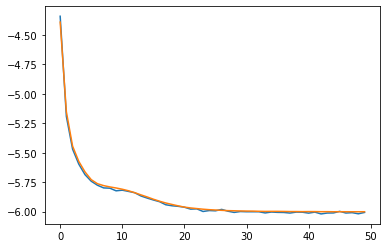

In [10]:
"""Get parameters for the model"""
MLP_tx_dim = [input_sizeTx, 256, 256, output_sizeTx]
MLP_rx_dim = [input_sizeRx, 128, 128, output_sizeRx]

'Calling the model'
model = BeamformingModel(MLP_tx_dim, MLP_rx_dim)

exp_id = strftime("%m-%d_%H_%M_%S", gmtime())
output_dir = f'/Users/seungcheoloh/Desktop/Primary/Research/DNN Applied P_MIMO/Two_Way_Method/trained_TwoWay_model/{exp_id}'

os.makedirs(output_dir, exist_ok=True)
print(output_dir)

# Setting learning rate and optimizers
learning_rate = 0.001
optimizer_bf = optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_bf, gamma=0.9992)

# Initializer
no_increase = 0 
best_loss = float('inf')

# Initizalize lists for data visualization
training_loss = []
test_loss = []
epochs = []

for epoch in tqdm(range(max_epochs)):
    batch_iter = 0
    
    for epoch_per_batch in range(n_epochs):
        model.train()
        rnd_indices = torch.randint(num_generated_sample, (batch_size,))
        H_p_batch = H_p_training_shaped[rnd_indices]
        y_tx_train = y_real_tx_train[rnd_indices]
        y_rx_train = y_real_rx_train[rnd_indices]

        # Zeros the gradients
        optimizer_bf.zero_grad()

        # Forward pass
        bf = model(H_p_batch, y_tx_train, y_rx_train)
        loss = beamforming_loss(bf)
        rate_training_loss = -torch.mean(torch.log2(1+SNR*torch.abs(bf)**2))

        # Backward propagation
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Set max_norm to your desired threshold
        
        # Optimizer
        optimizer_bf.step()
        lr_scheduler.step()
        batch_iter += 1

    """Evaluating Model"""
    model.eval()
    test_bf = model(H_p_testing_batch, y_real_tx_test, y_real_rx_test)
    rate_test_loss = -torch.mean(torch.log2(1+SNR*torch.abs(test_bf)**2))

    epochs.append(epoch)
    test_loss.append(rate_test_loss.detach().numpy())
    training_loss.append(rate_training_loss.detach().numpy())
    print('epoch', epoch, '  loss_train:%2.5f' % -rate_training_loss, '  loss_test:%2.5f' % -rate_test_loss, '  best_test:%2.5f  ' % -best_loss, 'no_increase:', no_increase, f"lr: {lr_scheduler.get_lr()}")
    
    if rate_test_loss < best_loss:
        torch.save(model.state_dict(), os.path.join(output_dir, f"{epoch}.pth"))
        best_loss = rate_test_loss 
        no_increase = 0
    else: 
        no_increase = no_increase + 1

    if no_increase > 20:
        break

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.savefig(os.path.join(output_dir, f"training_loss.png"))
plt.savefig(os.path.join(output_dir, f"test_loss.png"))
plt.show()